# Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

## План выполнения проекта:
1. **Загрузка данных**

    - Загрузить данные из файла: /datasets/taxi.csv
2. **Изучение данных**

    - Просмотреть структуру данных, типы столбцов и первые несколько строк.
    - Выявить пропущенные значения.

3. **Подготовка выборок для обучения**

    - Разделить данные на обучающую и тестовую выборки.
    - Определить целевую переменную и признаки для обучения.
4. **Обучение моделей**

    - Обучить несколько моделей, включая:
5. **Проверить данные на тестовой выборке и сделть выводы**

_____
**Оглавление**

[1. Загрузка данных](#step1)

[2. Изучение данных](#step2)

[3. Ресемплирование по одному часу](#step3)

[4. Анализ данных](#step4)

[5. Подготовка выборок для обучения](#step5)

[6. Обучение  моделей](#step6)

[6.1 Обучение модели RandomForestRegressor](#step6.1)

[6.2 Обучение модели LGBMRegressor](#step6.2)

[7. Проверка данных на тестовой выборке и выводы](#step7)

____

In [6]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [7]:
RANDOM_STATE = 42
TEST_SIZE = 0.1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

<a id='step1'></a>

## Загрузка данных

In [10]:
try:
    data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=['datetime'])

Столбец с датами определился некорректно (должен быть datetime64[ns]). Чтобы это исправить, использовали при чтении аргумент parse_dates

<a id='step2'></a>

## Изучение данных

In [14]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [16]:
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

Датасет taxi.csv представлен в виде двух столбцов и состоит из 26946 записей. Пропусков не обнаружено

<a id='step3'></a>

## Ресемплирование по одному часу

In [20]:
data.set_index('datetime', inplace=True)

In [21]:
data = data.resample('1H').sum()

In [22]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Сделали ресемплирование по одному часу

<a id='step4'></a>

## Анализ данных

In [27]:
decomposed = seasonal_decompose(data)

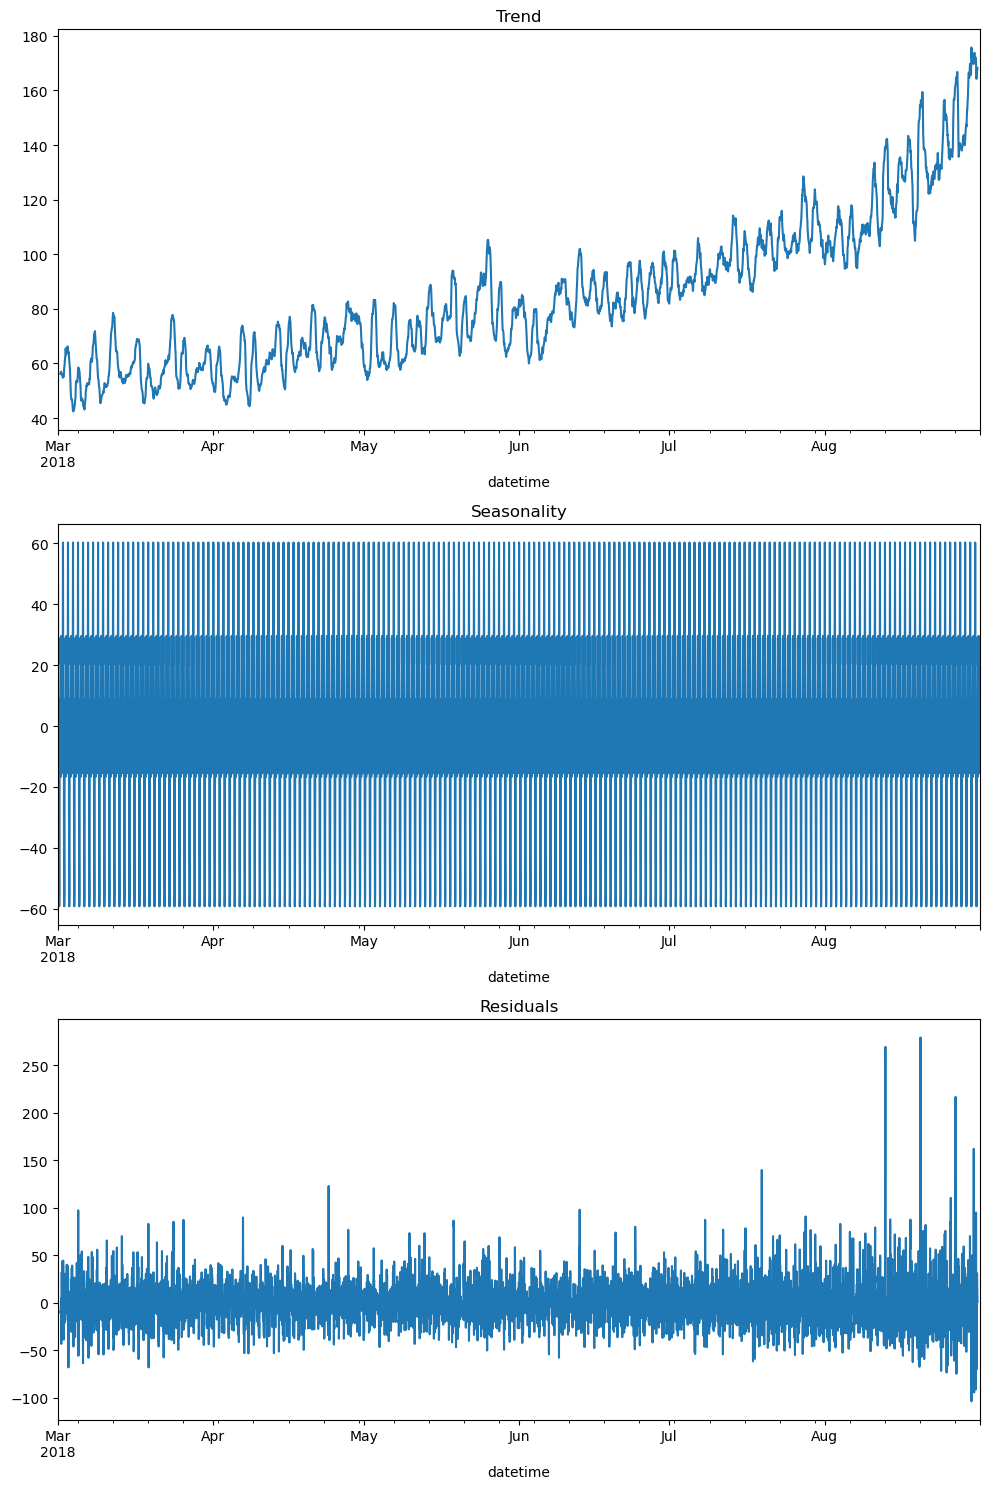

In [28]:
plt.figure(figsize=(10, 15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Первый график (Тренд): 
- Рост Наблюдается общий рост значений с течением времени. Присутствует восходящий тренд.
- Сезонность: На графике также видны колебания, что может указывать на сезонные изменения или на то, что данные могут иметь периодические циклы.

Второй график (Сезонность):

- Периодические колебания: График демонстрирует регулярные, повторяющиеся колебания, что подтверждает наличие сезонного компонента в данных.
- Стабильность: Эти колебания выглядят относительно постоянными по амплитуде, что говорит о том, что зависит от времени суток.
    
Третий график (Остатки): 

- Шум: Видны аномальные пики в числе заказов
- Нет явного тренда: Остатки не показывают никаких явных трендов или сезонных паттерновпоненты.


In [30]:
decomposed_sub = seasonal_decompose(data['2018-07-31':'2018-08-31'])

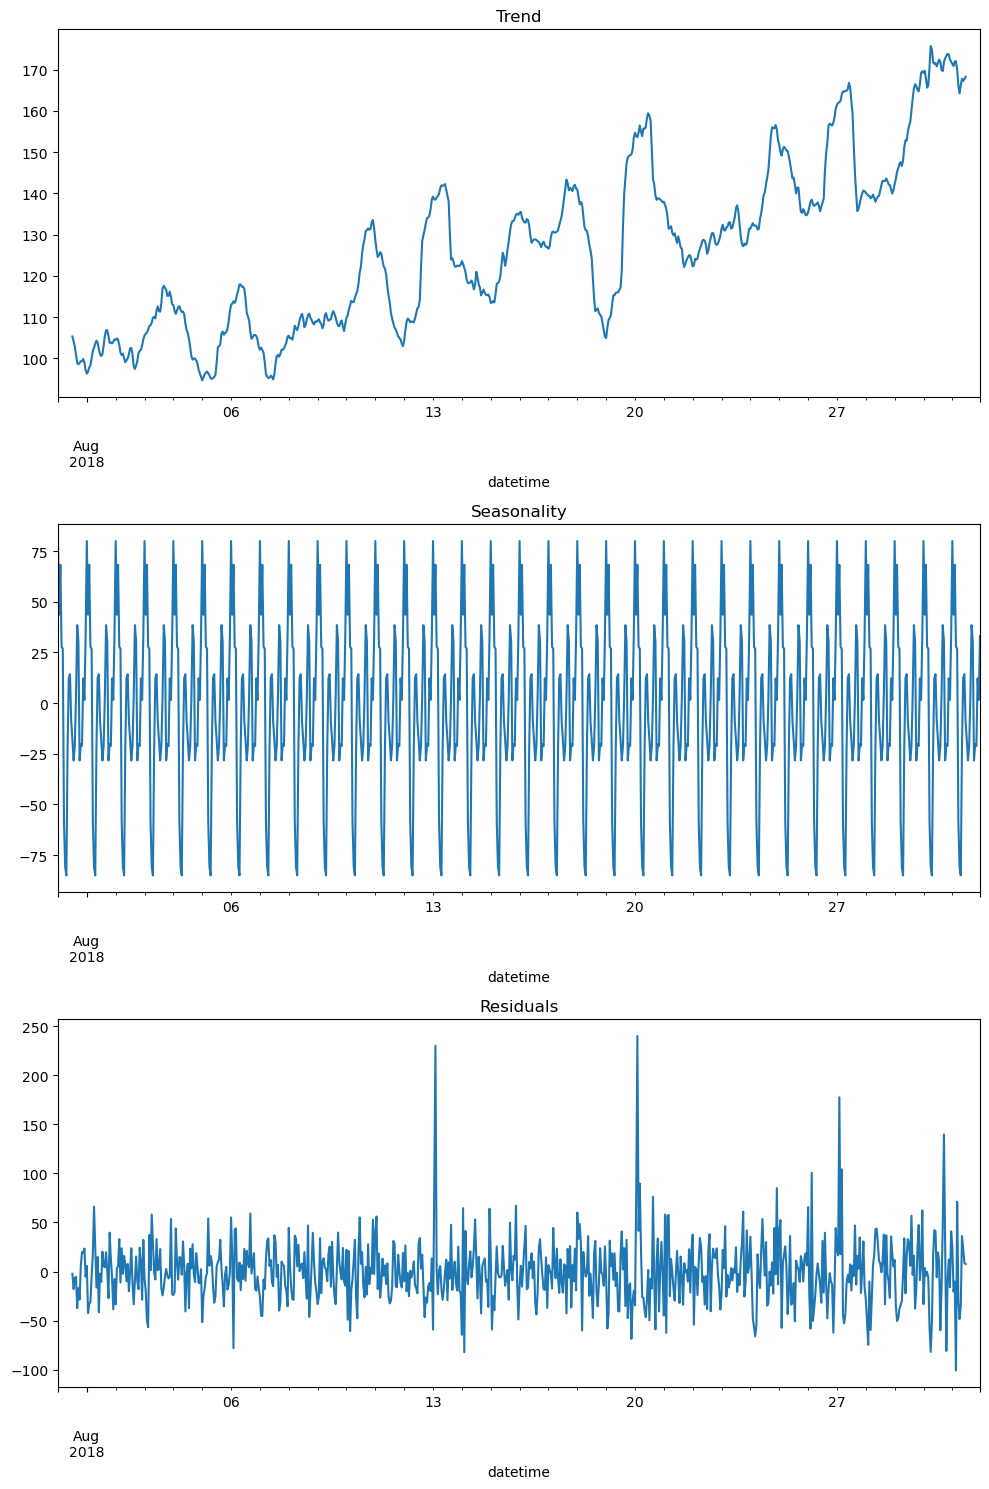

In [31]:
plt.figure(figsize=(10, 15))
plt.subplot(311)

decomposed_sub.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed_sub.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed_sub.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [32]:
#plt.figure(figsize=(12, 7))
#plt.plot(data.index, data['num_orders'], label='Число заказов', color='blue')
#plt.title('Число заказов такси по часам')
#plt.xlabel('Время')
#plt.ylabel('Число заказов')
#plt.legend()
#plt.grid()
#plt.tight_layout()
#plt.show()

In [33]:
#data.describe()

Первый график (Тренд): 

- Рост: Наблюдается общий рост значений с течением времени. Присутствует восходящий тренд.
- Сезонность: На графике также видны колебания, что может указывать на сезонные изменения или на то, что данные могут иметь периодические циклы.

Второй график (Сезонность):

- Периодические колебания: График показывает периодические пики и падения количества заказов, что подтверждает наличие сезонного компонента в данных.
- Стабильность: Характерно заметное изменение числа заказов от часов к часам, что указывает на волатильность в спросе на такси, возможно, в зависимости от внешних факторов
    
Третий график (Остатки): 

- Шум: Видны аномальные пики в числе заказов
- Нет явного тренда: Остатки не показывают никаких явных трендов или сезонных паттернов

<a id='step5'></a>

## Подготовка выборок для обучения

In [39]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [40]:
make_features(data, 24, 10)

In [41]:
data.head()

,num_orders,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
train, test = train_test_split(data, shuffle=False, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [45]:
print(f'Размер обучающей выборки: {len(train)}')
print(f'Размер тестовой выборки: {len(test)}')

Размер обучающей выборки: 3974
Размер тестовой выборки: 442


Сделали тестовую выборку размером 10% от исходных данных

<a id='step6'></a>

## Обучение  моделей

<a id='step6.1'></a>

### Обучение модели RandomForestRegressor

In [52]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [53]:
param_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'] 
}

In [54]:
tscv = TimeSeriesSplit(n_splits=3)

In [55]:
scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

In [56]:
rf_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    param_distributions=param_rf,
    n_iter=30,  
    cv=tscv,  
    scoring=scorer,
    random_state=RANDOM_STATE,
    verbose=2, 
    refit=True,
    n_jobs=-1  
)

In [57]:
rf_search.fit(features_train, target_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(), n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict', squared=False),
                   verbose=2)

In [58]:
rf_model = rf_search.best_estimator_

In [59]:
print(f"Лучшие параметры: {rf_search.best_params_}")
print(f"Лучший RMSE (neg_root_mean_squared_error): {-rf_search.best_score_:.2f}")

Лучшие параметры: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Лучший RMSE (neg_root_mean_squared_error): 26.44


____
Обучили модель RandomForestRegressor: 
- Лучшие параметры: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
- Лучший RMSE (neg_root_mean_squared_error): 26.50
____

<a id='step6.2'></a>

### Обучение модели LGBMRegressor

In [64]:
params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.7, 0.8, 0.9] 
}

In [65]:
lgb_search = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(),
    param_distributions=params,
    n_iter=30,  
    cv=tscv,  
    scoring=scorer,
    random_state=RANDOM_STATE,
    verbose=2, 
    refit=True,
    n_jobs=-1  
)

In [66]:
lgb_search.fit(features_train, target_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4867
[LightGBM] [Info] Number of data points in the train set: 3974, number of used features: 28
[LightGBM] [Info] Start training from score 78.290639


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=LGBMRegressor(), n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'min_child_samples': [10, 20, 30],
                                        'n_estimators': [100, 300, 500],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=42,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict', squared=False),
                   verbose=2)

In [67]:
lgb_model = lgb_search.best_estimator_

In [68]:
print(f"Лучшие параметры: {lgb_search.best_params_}")
print(f"Лучший RMSE (neg_root_mean_squared_error): {-lgb_search.best_score_:.2f}")

Лучшие параметры: {'subsample': 0.8, 'n_estimators': 300, 'min_child_samples': 20, 'learning_rate': 0.05}
Лучший RMSE (neg_root_mean_squared_error): 26.39


____
Обучили модель LGBMRegressor:
- Лучшие параметры: {'subsample': 0.8, 'n_estimators': 300, 'min_child_samples': 20, 'learning_rate': 0.05}
- Лучший RMSE (neg_root_mean_squared_error): 26.39
____

<a id='step7'></a>

## Проверка данных на тестовой выборке и выводы

In [74]:
lgb_predictions = lgb_model.predict(features_test)
lgb_rmse = np.sqrt(mean_squared_error(target_test, lgb_predictions))
print(f'RMSE для LGBM: {lgb_rmse:.2f}')

RMSE для LGBM: 41.31


На основании представленных значений RMSE (корень из среднеквадратичной ошибки)можно видеть, что:
- RMSE для LGBM: 41.31

По условиям задачи, значение метрики RMSE на тестовой выборке должно быть не больше 48. LGBM модель показала лучшие результаты. Ее и будем рекомендовать для решения поставленной задачи

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48